In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime
import time

%matplotlib inline

In [2]:
# Load dataset heroes
heroes = pd.read_csv('data/dictionaries/heroes.csv')
display(heroes.head(1))
print('Number of heroes in game:',sum(heroes['localized_name'].value_counts()))

,id,localized_name,name
0,1,Anti-Mage,antimage


Number of heroes in game: 112


In [3]:
# Load dataset
data_train = pd.read_csv('datasets/CleanDataTrain.csv')
data_test = pd.read_csv('datasets/CleanDataTest.csv')

In [4]:
#Create Bag of Words
X_pick = np.zeros((data_train.shape[0], len(heroes)))
for i, match_id in enumerate(data_train.index):
    for p in range(5):
        X_pick[i, data_train.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data_train.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
X_pick = pd.DataFrame(X_pick, index=data_train.index)

In [5]:
# Segregate features and labels into separate variables
X,y = data_train.iloc[:,0:103] , data_train.iloc[:,103]

In [6]:
# Instantiate StandardScaler and use it to rescale
scaler = StandardScaler()
rescaledX = pd.DataFrame(scaler.fit_transform(X), index = X.index)
rescaledX = pd.concat([rescaledX, X_pick], axis=1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [7]:
# Instantiate a LogisticRegression classifier and fit to the train set
kf = KFold(n_splits=5, shuffle=True, random_state=42)
result = []
tol = [0.1, 0.01, 0.001, 0.0001]
for i in tol:
    print(i)
    model = LogisticRegression(C=i, random_state=42)
    start_time = datetime.datetime.now()
    model_score = cross_val_score(model, rescaledX, y, cv=kf, scoring='roc_auc', n_jobs=-1)
    print('Time elapsed:', datetime.datetime.now() - start_time)
    print(model_score)
    result.append(np.mean(model_score))

0.1
Time elapsed: 0:00:16.060529
[0.74958128 0.75316458 0.74936888 0.75610987 0.7515484 ]
0.01
Time elapsed: 0:00:10.241486
[0.74964527 0.75280631 0.74910019 0.75549533 0.75169859]
0.001
Time elapsed: 0:00:06.646966
[0.74488327 0.74677747 0.7440329  0.74888913 0.74737192]
0.0001
Time elapsed: 0:00:04.134342
[0.72380823 0.72420431 0.72470572 0.72601444 0.72689278]


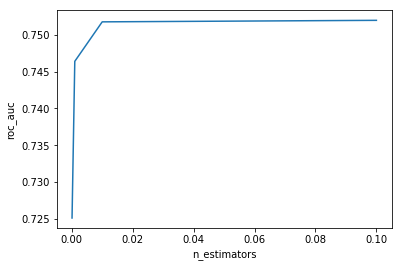

In [8]:
plt.plot(tol, result)
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.show()

In [9]:
max_score = " ".join([repr(tol[result.index(max(result))]), repr(round(max(result), 2))])
print(max_score)

0.1 0.75


1. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?


Качество увеличилось до 0,75. Мы превратили признаки, которые раньше модель распознавала как шум и которые не влияли на качество, в признаки относящие остальные данные в строке к двум командам. То есть добавили дополнительную разметку.

In [10]:
# Use LogisticRegression to predict instances from the test set and store it
model = LogisticRegression(C=0.1, random_state=42, n_jobs=-1)
model.fit(rescaledX, y,)

X_pick_test = np.zeros((data_test.shape[0], len(heroes)))
for i, match_id in enumerate(data_test.index):
    for p in range(5):
        X_pick_test[i, data_test.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_test[i, data_test.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
X_pick_test = pd.DataFrame(X_pick_test, index=data_test.index)


rescaledX_test = pd.DataFrame(scaler.fit_transform(data_test), index = data_test.index)
X_test = pd.concat([rescaledX_test, X_pick_test], axis=1)
y_pred = model.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [11]:
y_test = model.predict_proba(X_test)[:, 1]
radiant_win = pd.DataFrame({'radiant_win': y_test}, index=X_test.index)
radiant_win.index.name = 'match_id'

In [12]:
display(radiant_win.head())
display(radiant_win.tail())

,radiant_win
match_id,
0,0.830917
1,0.764284
2,0.197283
3,0.864723
4,0.240511


,radiant_win
match_id,
17172,0.734640
17173,0.646234
17174,0.242550
17175,0.635740
17176,0.439655


In [17]:
print(radiant_win.min())
print(radiant_win.max())

radiant_win    0.008701
dtype: float64
radiant_win    0.996568
dtype: float64


In [14]:
radiant_win.to_csv('kaggle.csv')